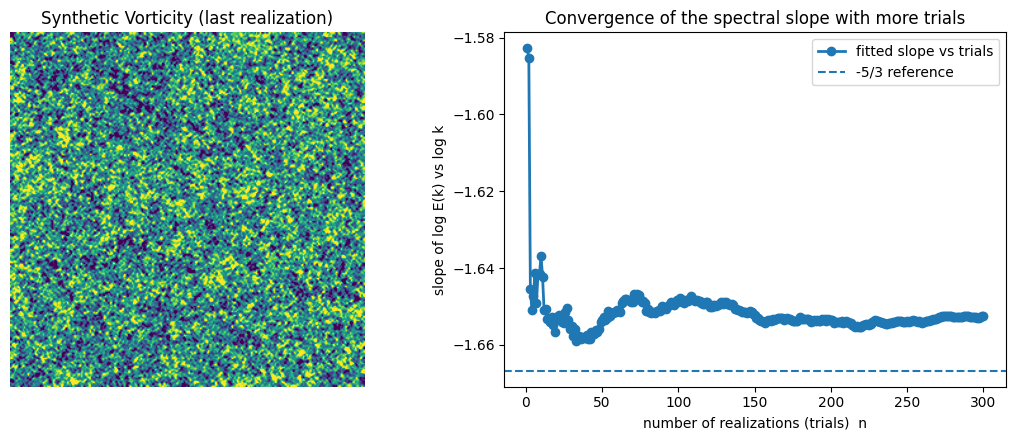

In [46]:

try:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

import numpy as np
import matplotlib.pyplot as plt

# ===== 파라미터 =====
N = 280
alpha = 4/3 # |û| ~ k^{-alpha}  -> shell-integrated E(k) ~ k^{1-2alpha} = k^{-5/3}
TRIALS = 300  # 시행(실현) 횟수
seed0 = 77       # 재현성용 시드 기준

# ===== 유틸 =====
def divergence_free_project(ux_hat, uy_hat, kx, ky):
    k2 = kx**2 + ky**2
    k_dot_u = kx*ux_hat + ky*uy_hat
    with np.errstate(divide='ignore', invalid='ignore'):
        factor = np.where(k2 == 0, 0.0, k_dot_u / k2)
    ux_hat -= factor * kx
    uy_hat -= factor * ky
    ux_hat[k2==0] = 0.0
    uy_hat[k2==0] = 0.0
    return ux_hat, uy_hat

# ===== k-공간 격자 (고정) =====
kx_1d = np.fft.fftfreq(N) * N
ky_1d = np.fft.fftfreq(N) * N
kx, ky = np.meshgrid(kx_1d, ky_1d, indexing='xy')
k = np.sqrt(kx**2 + ky**2); k[0,0] = 1.0
scale = k**(-alpha); scale[0,0] = 0.0

# 쉘 인덱스(고정)와 최대 인덱스
kr = np.rint(np.sqrt(kx**2 + ky**2)).astype(int)
kmax = kr.max()
kvals = np.arange(kmax+1)

# 누적 스펙트럼 합(쉘 적분)
E_sum = np.zeros(kmax+1, dtype=float)

# 시행별 기울기 기록
slope_hist = []

def guess_inertial_band(kv, Ek, nu=1e-3, cL=2.0, ceta=0.6):
    # integral scale L ~ ∫E/k / ∫E
    dk = 1.0
    num = np.sum(Ek / (kv + 1e-12)) * dk
    den = np.sum(Ek) * dk
    L = num / (den + 1e-12)

    # ε ~ 2 ν ∫ k^2 E(k) dk  (K41식)
    eps = 2.0 * nu * np.sum((kv**2) * Ek) * dk
    if eps <= 0:
        return None

    eta = (nu**3 / eps) ** 0.25

    kmin_auto = cL / L        # 1/L 보다 안쪽
    kmax_auto = ceta / eta    # 1/η 보다 바깥
    return kmin_auto, kmax_auto

# ===== 시행 반복 =====
for t in range(1, TRIALS+1):
    np.random.seed(seed0 + t)
    # 랜덤 속도장 -> 푸리에 -> 비압축성 -> Kolmogorov형 스케일링
    ux = np.random.normal(size=(N, N))
    uy = np.random.normal(size=(N, N))
    ux_hat = np.fft.fft2(ux); uy_hat = np.fft.fft2(uy)
    ux_hat, uy_hat = divergence_free_project(ux_hat, uy_hat, kx, ky)
    ux_hat *= scale; uy_hat *= scale

    # 에너지 스펙트럼(쉘 합) 누적
    energy_k = 0.5 * (np.abs(ux_hat)**2 + np.abs(uy_hat)**2)
    E_shell = np.bincount(kr.ravel(), weights=energy_k.ravel(), minlength=kmax+1)
    E_sum += E_shell

    # 누적 평균 스펙트럼으로 기울기 피팅 (관성구간 후보만)
    Ek_avg = E_sum[1:] / t
    kv = kvals[1:]

    # (추가) Kolmogorov 의미로 관성구간을 먼저 추정해본다
    band = guess_inertial_band(kv, Ek_avg, nu=1e-3)
    if band is not None:
        kmin_auto, kmax_auto = band
        # 실제 격자 범위에 맞게 정수화
        kmin_fit = max(2, int(kmin_auto))
        kmax_fit = min(int(kmax_auto), N//6)
    else:
        # 안 잡히면 원래 너가 쓰던 값으로
        kmin_fit, kmax_fit = 10, min(45, N//6)


    mask = (kv >= kmin_fit) & (kv <= kmax_fit)
    kv_fit = kv[mask]; Ev_fit = Ek_avg[mask]
    slope, intercept = np.polyfit(np.log(kv_fit+1e-12), np.log(Ev_fit+1e-12), 1)
    slope_hist.append(slope)

    # 마지막 시행의 와도 이미지를 왼쪽에 표시할 용도로 저장
    if t == TRIALS:
        ux_sp = np.fft.ifft2(ux_hat).real
        uy_sp = np.fft.ifft2(uy_hat).real
        omega = np.gradient(uy_sp, axis=1) - np.gradient(ux_sp, axis=0)

# ===== 플롯 =====
plt.figure(figsize=(11,4.5))

# (왼쪽) 와도 이미지 (대비 살짝)
plt.subplot(1,2,1)
vmin, vmax = np.percentile(omega, 5), np.percentile(omega, 95)
plt.imshow(omega, origin='lower', interpolation='bilinear', vmin=vmin, vmax=vmax)
plt.title('Synthetic Vorticity (last realization)')
plt.axis('off')

# (오른쪽) 시행횟수에 따른 기울기 수렴
n = np.arange(1, TRIALS+1)
plt.subplot(1,2,2)
plt.plot(n, slope_hist, marker='o', linewidth=2, label='fitted slope vs trials')
plt.axhline(-5/3, linestyle='--', label='-5/3 reference')
plt.xlabel('number of realizations (trials)  n')
plt.ylabel('slope of log E(k) vs log k')
plt.title('Convergence of the spectral slope with more trials')
plt.legend()
plt.tight_layout()
plt.show()
